In [4]:
import os
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
import scipy.io
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2 as cv
import math

# defined
from utility_function import img_resize, model_namer, model_namer_description, save_ml_model, load_ml_model, load_training_data

In [313]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Extract only the defect (4/4/23)

[24, 54, 34, 78]

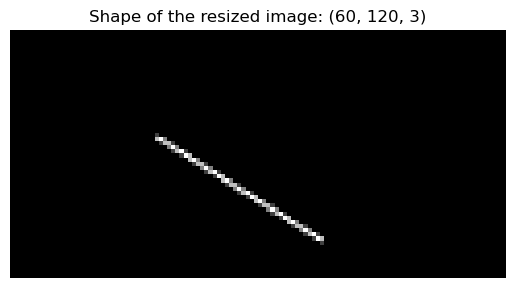

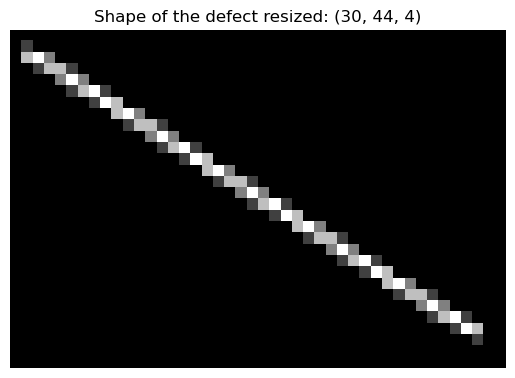

In [20]:
# defect plotting function
def plot_defect_zoom(defect, index = -999, plot = False):
    
    '''
    Date: 22/3/23
    This function assumes array = False
    y_shift = 60, 
    backwall = False, 
    save = False, 
    crop = True
    
    '''
    y_shift = 60
    scale_percent = 50
    
    # y_shift controls the offset of the image (shift up)
    
    color = (255, 255, 255) # White color
    
    # Extract defect data from the array
    defWidth, defHeight, defPosx, defPosy, defAngR = defect
    
    # define an image
    # np.zeros(height,width)
    
    # Assumed the image is croped
    img = np.zeros((120,240,3), np.uint8)
    
    # Transform defect size to pixel size
    pixel_step = 0.5e-3
    pixel_width = defWidth / pixel_step
    pixel_height = defHeight / pixel_step
    x = np.arange(-0.06, 0.06, pixel_step) # length = 240
    y = np.arange(0, 0.06, pixel_step) # length = 180
    
    # Function that takes in an array and a target value, 
    # return the index of an element that is nearest to the target value
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        # Return index
        return idx
    
    pixel_xc = find_nearest(x, defPosx)
    pixel_yc = 180 - find_nearest(y, defPosy)
    
    # add a negative sign to convert from clockwise to anticlockwise    
    defAngR = -defAngR
    
    # compute sine and cosine
    cos_theta, sin_theta = np.cos(defAngR), np.sin(defAngR)
    
    # let w and h be half of the width and height
    w, h = pixel_width/2, pixel_height/2
    
    
    # Coordinate: check the notes for details
    # left up corner
    x1, y1 = (pixel_xc - w*cos_theta - h*sin_theta), (pixel_yc - w*sin_theta + h*cos_theta - y_shift)
    # right up corner
    x2, y2 = (pixel_xc + w*cos_theta - h*sin_theta), (pixel_yc + w*sin_theta + h*cos_theta - y_shift)
    # right down corner
    x3, y3 = (pixel_xc + w*cos_theta + h*sin_theta), (pixel_yc + w*sin_theta - h*cos_theta - y_shift)
    # left down corner
    x4, y4 = (pixel_xc - w*cos_theta + h*sin_theta), (pixel_yc - w*sin_theta - h*cos_theta - y_shift)
    
    pts = np.array([[x1, y1],[x2, y2],[x3, y3],[x4, y4]], np.int32)
    # print(pts)
    
    # reformat the points
    pts = pts.reshape((-1,1,2))
    
    img = cv.fillPoly(img,[pts], color) 
    # print(img.shape)
    
#     if plot == True:
#     # Plot the image
#         fig, ax = plt.subplots()
#         ax.imshow(img)
#         plt.title(f'Shape of the image: {img.shape}')
#         plt.axis('off')
    
    # Plot the defect of the resize image
    img_defect = cv.cvtColor(img, cv.IMREAD_GRAYSCALE)[int(min([y1, y2, y3, y4])-2): int(max([y1, y2, y3, y4])+2), 
                                                       int(min([x1, x2, x3, x4])-2): int(max([x1, x2, x3, x4])+2)]
    
#     if plot == True:
#         fig, ax = plt.subplots()
#         ax.imshow(img_defect)
#         plt.title(f'Shape of the defect: {img_defect.shape}')
#         plt.axis('off')
    
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # Resize image
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    if plot == True:
        fig, ax = plt.subplots()
        ax.imshow(resized)
        plt.title(f'Shape of the resized image: {resized.shape}')
        plt.axis('off')
    
    # Plot the defect of the resize image
    yleft, yright = int(math.ceil(min(y1, y2, y3, y4)/2)-2), int(math.ceil(max(y1, y2, y3, y4)/2)+2)
    xleft, xright = int(math.ceil(min(x1, x2, x3, x4)/2)-2), int(math.ceil(max(x1, x2, x3, x4)/2)+2)
    img_defect_resized = cv.cvtColor(resized, cv.IMREAD_GRAYSCALE)[yleft: yright, xleft: xright]
    if plot == True:
        fig, ax = plt.subplots()
        ax.imshow(img_defect_resized)
        plt.title(f'Shape of the defect resized: {img_defect_resized.shape}')
        plt.axis('off')
    
    return img_defect_resized, [yleft, yright, xleft, xright]
    
# defect = [0.0287, 0.0010, -0.0189, 0.0375, -0.5626]
# defect = [0.0128, 0.0010, -0.0390, 0.0194, -1.5085]
defect = [0.047034, 0.001, -0.004513, 0.021404, -0.562620]

_, coordinate = plot_defect_zoom(defect, plot = True)
coordinate

## Crop the DAS Image for comparison

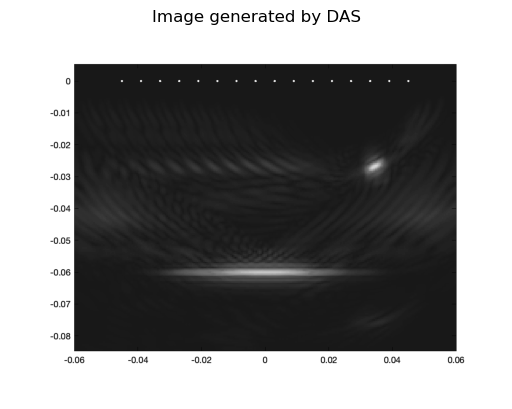

(60, 120)


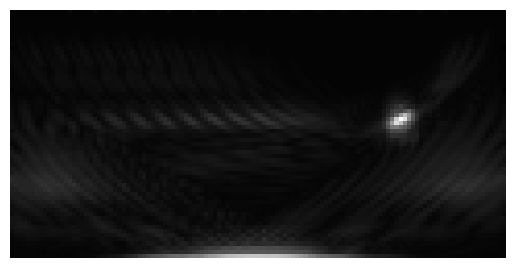

In [16]:
index = 50
dirName_das_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_FMC"
# Read image in greyscale 
image_das_fmc = cv.imread(f'{dirName_das_fmc}/Figure_{index}_fmc.png',cv.IMREAD_GRAYSCALE)  # convert to array
fig, ax = plt.subplots()
plt.imshow(image_das_fmc, cmap='gray')
plt.title('Image generated by DAS')
plt.axis('off')
plt.show()

# Crop the ultrasound array and the backwall and scale it to 0-1

def DAS_image_resize(image_das_fmc):
    cropped_image = image_das_fmc[125:575, 155:1055]/255
    scale_percent = 50
    width = int(240 * scale_percent / 100)
    height = int(120 * scale_percent / 100)
    dim = (width, height)
    das_img_resize = cv.resize(cropped_image, dim, interpolation=cv.INTER_AREA)
#     return cropped_image
    return das_img_resize

das_img_resize = DAS_image_resize(image_das_fmc)
print(das_img_resize.shape)
plt.imshow(das_img_resize, cmap='gray')
plt.axis('off')
plt.show()

## Load model

In [13]:
# model testing

# filename = '3d_cnn2.h5'
# filename = '3d_cnn3.h5'
# img_resize_factor = 100

# filename = 'cnn3d_100_5_1.75e-14_100_1_relu_50.h5'
# filename = 'cnn3d_100_5_1.75e-14_50_1_relu_50.h5'
# filename = 'cnn3d_1000_5_1.75e-14_40_1_tanh_1.h5'
# filename = 'cnn2d_1000_5_1.75e-14_50_1_relu_100.h5'
# filename = 'cnn2d_1000_5_1.75e-14_100_1_tanhmax_100.h5'
# filename = 'cnn3d_2000_5_1.75e-14_50_1_relu-dense_1.pkl'
# filename = 'cnn2d_1000_5_1.75e-14_50_255_max_100.pkl'
# filename = 'cnn2d_1000_5_1.75e-14_50_255_max_100.pkl'
# filename = 'cnn2d_v1_1000_5_1.75e-14_50_max-based_100.pkl'
# filename = 'cnn2d_v2_1000_5_1.75e-14_50_shrinkX_100.pkl'
# filename = 'cnn3d_v1_1000_5_1.75e-14_50_shrinkX-tanh_10.pkl' # do not predict anything
# filename = 'cnn2d_v3_1000_5_1.75e-14_50_stack-2d_10.pkl' # do not predict anything
# filename = 'cnn2d_v3_1000_5_1.75e-14_50_no-pooling_100.pkl' # do not predict anything
# filename = 'cnn2d_v4_1000_5_1.75e-14_50_pooling_100.pkl'
# filename = 'cnn3d_v2_1000_5_1.75e-14_50_pooling_100.pkl'
# filename = 'cnn3d_v3_1000_5_1.75e-14_50_2-3dconv_100.pkl' # do not predict anything
# filename = 'cnn3d_v3_1000_5_1.75e-14_50_pooling-lr_100.pkl'

# filename = 'cnn3d_v3_2000_5_1.75e-14_50_kt-all_100.pkl'
filename = '3D_2450_o7167535.pkl'
# filename = '2D_2450_o7165279-1.pkl'
# info = model_namer_description(filename)
model = load_ml_model(filename)
model.summary()

Metal device set to: Apple M1 Pro


2023-04-04 13:46:04.717471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-04 13:46:04.719164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 892, 14, 14, 6)    222       
                                                                 
 dropout (Dropout)           (None, 892, 14, 14, 6)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 446, 7, 7, 6)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 131124)            0         
                                                                 
 dense (Dense)               (None, 2000)              262250000 
                                                                 
 dense_1 (Dense)             (None, 7200)              14407200  
                                                        

## Load dataset

In [14]:
# Load data from pkl file
# x_dimension = int(info['Dimension'])
# img_resize_factor = int(info['img_resize'])
# epochs = int(info['epochs'])

x_dimension= 3
img_resize_factor = 50
shrinkx = False

X, y = load_training_data(num_sample=3500, 
                          x_dimension=x_dimension, 
                          img_resize_factor=img_resize_factor,
                          shrinkx = shrinkx)

config = {'x_dimension':x_dimension,
         'img_resize_factor':img_resize_factor,
         'shrinkx':shrinkx}

The shape of X is (3500, 895, 16, 16, 1)
The shape of y is (3500, 7200)


## Check the performance of the data

num_test = 2200
Corrsponding index of the image = 2201
1/1 [==============================] - 0s 40ms/step
(7200,) (1, 7200)
MSE_keras is 0.0203312933
MSE_modified is 0.0052633821
MSE_modified_DAS is 0.0730811642
defect width = 0.0237042692445295
defect centre position = (0.0390502383749145, 0.0243225136142029)
defect angle = 44.8933866446101 degrees


(0.02033129334449768, 0.005263382103294134, 0.07308116416309335)

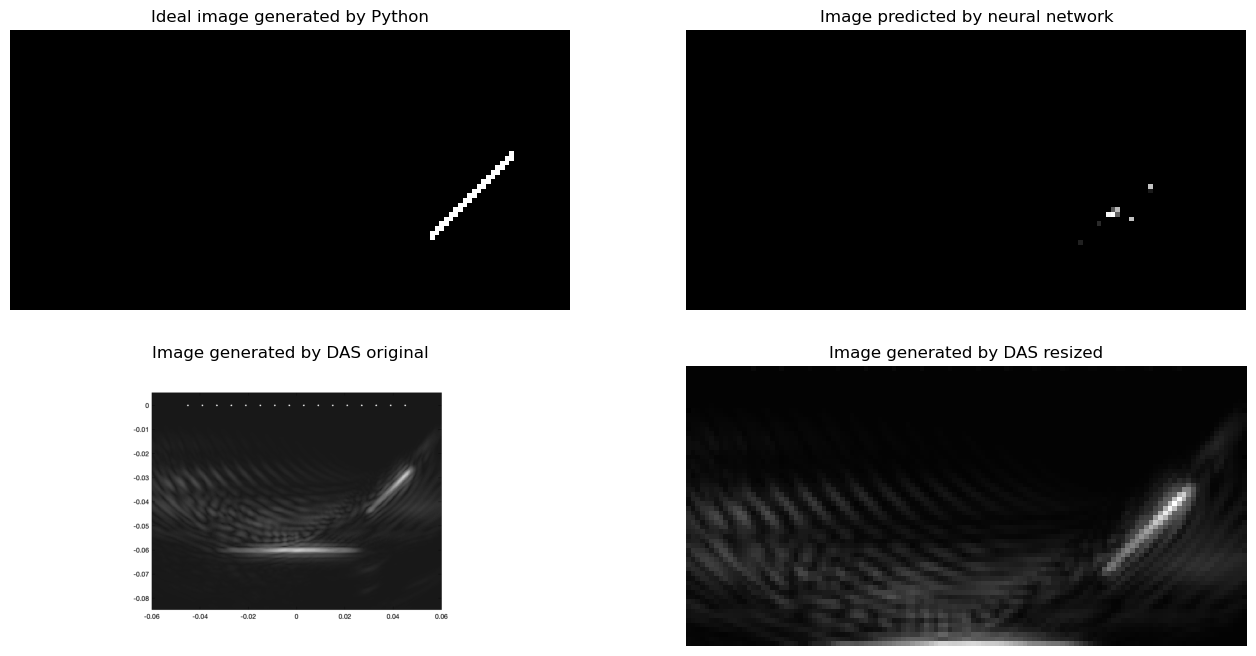

In [65]:

# Good: 2500 2600 2700 2742
# Not so good: 3122 2289 2383 3408
# Very bad: 3061 2797

import random
# num_test = random.randint(2000, 3499)
num_test = 2600


def check_result(config, model, num_test):
    print(f'num_test = {num_test}')
    print(f'Corrsponding index of the image = {num_test+1}')
    
    x_dimension = config['x_dimension']
    img_resize_factor = config['img_resize_factor']
    shrinkx = config['shrinkx']
    
    threshold = -0.1 
    stack = False

    # 1. Plotting the true_img (ideal image) generated by python

    true_img = y[num_test].reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
    
    # true_img is a matrix with only -1 and 1, now, for plotting, we change all -1 to 0
    true_img_modified = true_img.copy()
    true_img_modified[true_img_modified == -1] = 0
    
    fig, ax = plt.subplots(2,2, figsize = [16,8])
    ax[0,0].imshow(true_img_modified, cmap ='gray')
    ax[0,0].set_title('Ideal image generated by Python')
    ax[0,0].axis('off')

    # 2. Plotting the image predicted by Python

    if shrinkx == True:
        xshape = 865
    else:
        xshape = 895

    if x_dimension == 3:
        ypred = model.predict(X[num_test].reshape(-1, xshape, 16, 16, 1))
        
    elif x_dimension == 2:
        if stack == True:
            ypred = model.predict(X[num_test].reshape(-1, xshape, 16, 16))
        else:
            ypred = model.predict(X[num_test].reshape(-1, xshape, 16*16, 1))
            
    # Calculate MSE of the prediction

    print(y[num_test].shape, ypred.shape)
    mse = tf.keras.losses.MeanSquaredError()
    MSE = float(mse(y[num_test].reshape(1,-1), ypred.reshape(1,-1)).numpy()) # Use the unreshaped true_img to calculate MSE
    print(f'MSE_keras is {round(MSE,10)}')

    # MSE2 = np.sum(np.square(true_img.reshape(1, -1) - ypred.reshape(1, -1)))/len(true_img.reshape(1, -1))
    # print(f'MSE_formula is {round(MSE2,10)}')

    # Apply a threshold: the output from ypred is a matrix with number between -1 and 1
    # For plotting purpose, we set any value less or equal the threshold to 0. 
    ypred[ypred <= threshold] = 0
    # We set any value above the threshold to its absolute value
    ypred[ypred > threshold] = np.abs(ypred[ypred > threshold])#*255
    # For example, if threshold = -0.1, the value of -0.2 will be changed to 0
    # the value of -0.03 will be changed to 0.03
    # the value of 0.1 will still be 0.1
    
    img = ypred.reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
    
    # Calculate the modified MSE (after applying the threshold and modifying the true_img)
    MSE_modified = float(mse(true_img_modified.reshape(1,-1), img.reshape(1,-1)).numpy()) # Use the unreshaped true_img to calculate MSE
    print(f'MSE_modified is {round(MSE_modified,10)}')

    ax[0,1].imshow(img, cmap ='gray')
    ax[0,1].set_title('Image predicted by neural network')
    ax[0,1].axis('off')


    # 3. Plotting the DAS image produced by MATLAB

    dirName_das_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_FMC"
    # Read image in greyscale 
    image_das_fmc = cv.imread(f'{dirName_das_fmc}/Figure_{num_test+1}_fmc.png',cv.IMREAD_GRAYSCALE)  # convert to array
    
    ax[1,0].imshow(image_das_fmc, cmap='gray')
    ax[1,0].set_title('Image generated by DAS original')
    ax[1,0].axis('off')
    
    # Crop and resize the das image
    das_img_resize = DAS_image_resize(image_das_fmc)
    ax[1,1].imshow(das_img_resize, cmap='gray')
    ax[1,1].set_title('Image generated by DAS resized')
    ax[1,1].axis('off')
    
    # Calculate the modified MSE for DAS image for comparison (after cropping and resizing)
    MSE_modified_das = float(mse(true_img_modified.reshape(1,-1), das_img_resize.reshape(1,-1)).numpy()) # Use the unreshaped true_img to calculate MSE
    print(f'MSE_modified_DAS is {round(MSE_modified_das,10)}')
    
    df_concat = pd.read_csv('/Users/chenkangan/PycharmProjects/ME4_FYP_py/defect_3500.csv')
    df_concat = df_concat.set_index('index')
    defect = df_concat.loc[num_test+1]
    print(f'defect width = {defect.defWidth}')
    print(f'defect centre position = {(defect.defPosx, defect.defPosy)}')
    print(f'defect angle = {defect.defAng} degrees')
    
    return MSE, MSE_modified, MSE_modified_das


check_result(config, model, 2200)

num_test = 2500
Corrsponding index of the image = 2501
1/1 [==============================] - 0s 29ms/step
(7200,) (1, 7200)
MSE_keras is 4.6579e-05
MSE_modified is 2.85452e-05
MSE_modified_DAS is 0.0712982594
--------------------------------------------------
defect width = 0.032194348539476
defect centre position = (0.0235773219777944, 0.0302175516418052)
defect angle = 69.5080385378533 degrees
--------------------------------------------------
MSE_modified_defect_NN is 0.868224144
MSE_modified_defect_DAS is 1.4350730304


(4.657899626181461e-05,
 2.8545167879201472e-05,
 0.07129825938527369,
 0.8682241439819336,
 0.8682241439819336,
 1.4350730303881285)

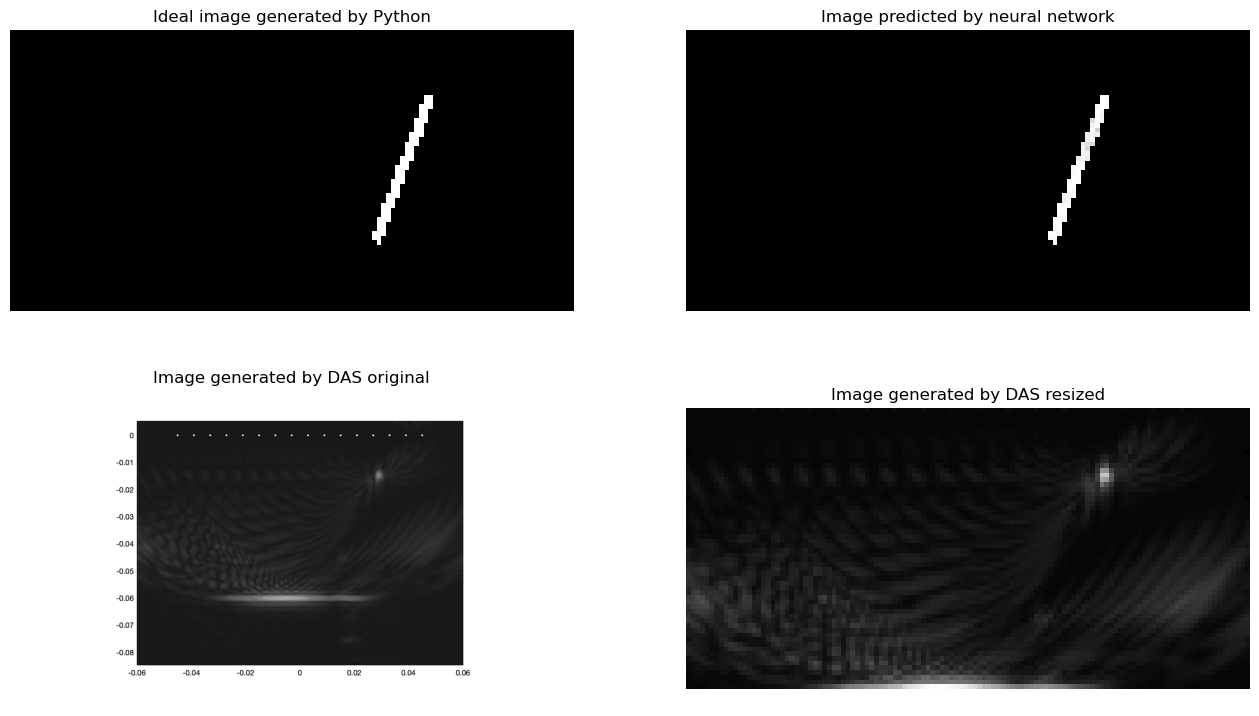

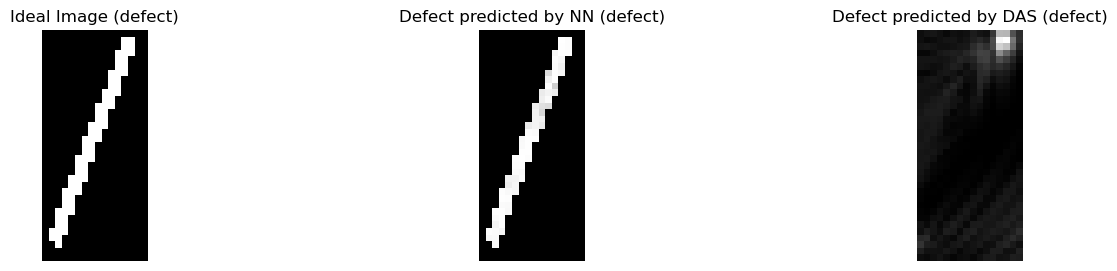

In [69]:
# last update: 4/4/23

# Check result version 2 (include the feature of plotting the defect only)
import random
# num_test = random.randint(2000, 3499)
num_test = 2600


def check_result_v2(config, model, num_test):
    print(f'num_test = {num_test}')
    print(f'Corrsponding index of the image = {num_test+1}')
    
    x_dimension = config['x_dimension']
    img_resize_factor = config['img_resize_factor']
    shrinkx = config['shrinkx']
    
    threshold = -0.1 
    stack = False

    # 1. Plotting the true_img (ideal image) generated by python

    true_img = y[num_test].reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
    
    # true_img is a matrix with only -1 and 1, now, for plotting, we change all -1 to 0
    true_img_modified = true_img.copy()
    true_img_modified[true_img_modified == -1] = 0
    
    fig, ax = plt.subplots(2,2, figsize = [16,9])
    ax[0,0].imshow(true_img_modified, cmap ='gray')
    ax[0,0].set_title('Ideal image generated by Python')
    ax[0,0].axis('off')

    # 2. Plotting the image predicted by Python

    if shrinkx == True:
        xshape = 865
    else:
        xshape = 895

    if x_dimension == 3:
        ypred = model.predict(X[num_test].reshape(-1, xshape, 16, 16, 1))
        
    elif x_dimension == 2:
        if stack == True:
            ypred = model.predict(X[num_test].reshape(-1, xshape, 16, 16))
        else:
            ypred = model.predict(X[num_test].reshape(-1, xshape, 16*16, 1))
            
    # Calculate MSE of the prediction

    print(y[num_test].shape, ypred.shape)
    mse = tf.keras.losses.MeanSquaredError()
    MSE = float(mse(y[num_test].reshape(1,-1), ypred.reshape(1,-1)).numpy()) # Use the unreshaped true_img to calculate MSE
    print(f'MSE_keras is {round(MSE,10)}')

    # MSE2 = np.sum(np.square(true_img.reshape(1, -1) - ypred.reshape(1, -1)))/len(true_img.reshape(1, -1))
    # print(f'MSE_formula is {round(MSE2,10)}')

    # Apply a threshold: the output from ypred is a matrix with number between -1 and 1
    # For plotting purpose, we set any value less or equal the threshold to 0. 
    ypred[ypred <= threshold] = 0
    # We set any value above the threshold to its absolute value
    ypred[ypred > threshold] = np.abs(ypred[ypred > threshold])#*255
    # For example, if threshold = -0.1, the value of -0.2 will be changed to 0
    # the value of -0.03 will be changed to 0.03
    # the value of 0.1 will still be 0.1
    
    img = ypred.reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
    
    # Calculate the modified MSE (after applying the threshold and modifying the true_img)
    MSE_modified = float(mse(true_img_modified.reshape(1,-1), img.reshape(1,-1)).numpy()) # Use the unreshaped true_img to calculate MSE
    print(f'MSE_modified is {round(MSE_modified,10)}')

    ax[0,1].imshow(img, cmap ='gray')
    ax[0,1].set_title('Image predicted by neural network')
    ax[0,1].axis('off')

    # 3. Plotting the DAS image produced by MATLAB

    dirName_das_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_FMC"
    # Read image in greyscale 
    image_das_fmc = cv.imread(f'{dirName_das_fmc}/Figure_{num_test+1}_fmc.png',cv.IMREAD_GRAYSCALE)  # convert to array
    
    ax[1,0].imshow(image_das_fmc, cmap='gray')
    ax[1,0].set_title('Image generated by DAS original')
    ax[1,0].axis('off')
    
    # Crop and resize the das image
    das_img_resize = DAS_image_resize(image_das_fmc)
    ax[1,1].imshow(das_img_resize, cmap='gray')
    ax[1,1].set_title('Image generated by DAS resized')
    ax[1,1].axis('off')
    
    # Calculate the modified MSE for DAS image for comparison (after cropping and resizing)
    MSE_modified_das = float(mse(true_img_modified.reshape(1,-1), das_img_resize.reshape(1,-1)).numpy()) # Use the unreshaped true_img to calculate MSE
    print(f'MSE_modified_DAS is {round(MSE_modified_das,10)}')
    print('--------------------------------------------------')
    
    df_concat = pd.read_csv('/Users/chenkangan/PycharmProjects/ME4_FYP_py/defect_3500.csv')
    df_concat = df_concat.set_index('index')
    defect = df_concat.loc[num_test+1]
    print(f'defect width = {defect.defWidth}')
    print(f'defect centre position = {(defect.defPosx, defect.defPosy)}')
    print(f'defect angle = {defect.defAng} degrees')
    print('--------------------------------------------------')
    
     # 4. Compute the MSE for the defect only
    defect = [defect.defWidth, defect.defHeight, defect.defPosx, defect.defPosy, defect.defAngR]
    _, [yleft, yright, xleft, xright] = plot_defect_zoom(defect)
    
    true_img_defect = true_img[yleft: yright, xleft: xright] # True image
    img_defect = img[yleft: yright, xleft: xright] # Image predicted by NN
    das_img_resize_defect = das_img_resize[yleft: yright, xleft: xright] # Image predicted by DAS
    
    fig2, ax2 = plt.subplots(1,3, figsize = [16,3])
    ax2[0].imshow(true_img_defect, cmap='gray')
    ax2[0].set_title('Ideal Image (defect)')
    ax2[0].axis('off')
    
    ax2[1].imshow(img_defect, cmap='gray')
    ax2[1].set_title('Defect predicted by NN (defect)')
    ax2[1].axis('off')
    
    ax2[2].imshow(das_img_resize_defect, cmap='gray')
    ax2[2].set_title('Defect predicted by DAS (defect)')
    ax2[2].axis('off')
    
    # Calculate the modified MSE (after applying the threshold, modifying the true_img)
    MSE_modified_defect = float(mse(true_img_defect.reshape(1, -1), img_defect.reshape(1, -1)).numpy()) # Use the unreshaped true_img to calculate MSE
    MSE_modified_defect_DAS = float(mse(true_img_defect.reshape(1, -1), das_img_resize_defect.reshape(1, -1)).numpy()) # Use the unreshaped true_img to calculate MSE
    
    print(f'MSE_modified_defect_NN is {round(MSE_modified_defect,10)}')
    print(f'MSE_modified_defect_DAS is {round(MSE_modified_defect_DAS,10)}')

    
    return MSE, MSE_modified, MSE_modified_das, MSE_modified_defect, MSE_modified_defect, MSE_modified_defect_DAS


check_result_v2(config, model, 2500)

### Summarise all the loss (MSE) to a dataframe (6/3/23)

In [181]:
df_concat = pd.read_csv('/Users/chenkangan/PycharmProjects/ME4_FYP_py/defect_3500.csv')
df_concat = df_concat.set_index('index')
# exclude the first 2000 data in the dataset, because they are trained
# the remaining 1500 data are untrained
df_concat_test = df_concat.loc[2001:]  

# Only run this below code when needed
# MSE_list = []
# MSE_modified_list = []
# for i in list(df_concat_test.index):
#     MSE, MSE_modified = check_result(config, int(i-1))
#     MSE_list.append(MSE)
#     MSE_modified_list.append(MSE_modified)
    
# df_concat_test['MSE_keras'] = MSE_list
# df_concat_test['MSE_modified_list'] = MSE_modified_list

In [176]:
df_concat_test.tail()

,defWidth,defHeight,defPosx,defPosy,defAng,defAngR,timestamp,MSE_keras,MSE_modified_list
index,,,,,,,,,
3496.0,0.035968,0.001,-0.009394,0.041426,-35.127629,-0.613093,02-Feb-2023 13:44:16,0.041670,0.010395
3497.0,0.049564,0.001,-0.020271,0.011584,9.532821,0.166379,02-Feb-2023 13:45:23,0.037400,0.011184
3498.0,0.007729,0.001,0.030884,0.031550,-19.985680,-0.348816,02-Feb-2023 13:46:32,0.006951,0.001999
3499.0,0.026787,0.001,-0.031829,0.012044,-14.355816,-0.250556,02-Feb-2023 13:47:38,0.030504,0.008167
3500.0,0.003758,0.001,0.009092,0.026454,-49.640926,-0.866398,02-Feb-2023 13:48:46,0.004977,0.001286


Original Dimensions :  (60, 120)
Resized Dimensions :  (120, 240)


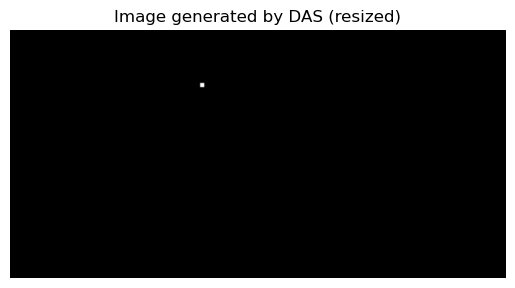

In [163]:
# Increase the size of the image by 200%

print('Original Dimensions : ',img.shape)
 
scale_percent = 200 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
plt.imshow(resized, cmap='gray')
plt.title('Image generated by DAS (resized)')
plt.axis('off')
plt.show()


## Prediction on FMC with noises (6/3/23)

Image index: 3508
Image noise level: 10
1/1 [==============================] - 0s 42ms/step


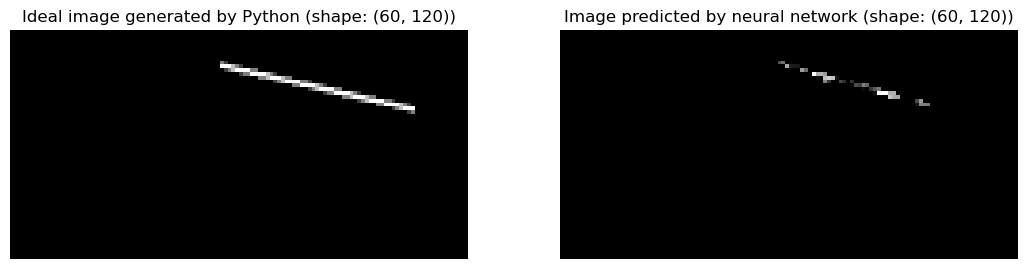

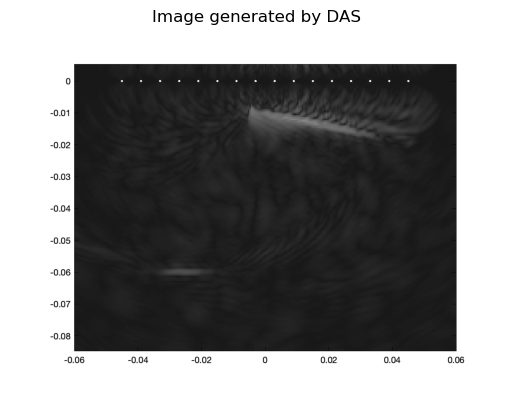

In [368]:
# Load noise data from each individual fmc file

filename = 'fmc_3501_40'

def check_result_with_noise(model, filename):
    [_, index, noise_level] = filename.split('_')

    print(f'Image index: {index}')
    print(f'Image noise level: {noise_level}')

    # 1. Plotting the true_img (ideal image) generated by python 

    img_resize_factor = 50

    true_img_dirname = '/Users/chenkangan/PycharmProjects/ME4_FYP_py/py_output_fig_no_backwall_crop'

    true_img = cv.imread(f'{true_img_dirname}/defect_{index}_yshift_60.png',cv.IMREAD_GRAYSCALE)
    true_img_scale = img_resize(true_img, scale_percent = img_resize_factor) # Resize the image

    fig, ax = plt.subplots(1,2, figsize = [13,5])
    ax[0].imshow(true_img_scale, cmap ='gray')
    ax[0].set_title(f'Ideal image generated by Python (shape: {true_img_scale.shape})')
    ax[0].axis('off')

    # 2. Plotting the image predicted by Python
    fmc_dirname = '/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/FMC_variable_noise'
    mat = scipy.io.loadmat(f'{fmc_dirname}/{filename}.mat')
    fmc = mat['timeTraces'][::5] # Subsampling 
    X_test = fmc.reshape(1, 895, 16, 16, 1) # Reshaping
    X_test = X_test/1.75e-14 # Scaling

    threshold = -0.1

    ypred = model.predict(X_test[0].reshape(-1, 895, 16, 16))
    ypred[ypred <= threshold] = 0
    ypred[ypred > threshold] = np.abs(ypred[ypred > threshold])*255
    img = ypred.reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))

    ax[1].imshow(img, cmap ='gray')
    ax[1].set_title(f'Image predicted by neural network (shape: {img.shape})')
    ax[1].axis('off')


    # 3. Plotting the DAS image produced by MATLAB
    das_fmc_dirName = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_FMC_noise"
    # Read image in greyscale 
    image_das_fmc = cv.imread(f'{das_fmc_dirName}/Figure_{index}_{noise_level}_fmc.png',cv.IMREAD_GRAYSCALE)  # convert to array
    fig, ax = plt.subplots()
    plt.imshow(image_das_fmc, cmap='gray')
    plt.title('Image generated by DAS')
    plt.axis('off')
    plt.show()
    
check_result_with_noise(model, filename = 'fmc_3508_10')

## Prediction on FMC with offsets (11/3/23)

Image index: 3601
Image noise level: 0
1/1 [==============================] - 0s 43ms/step


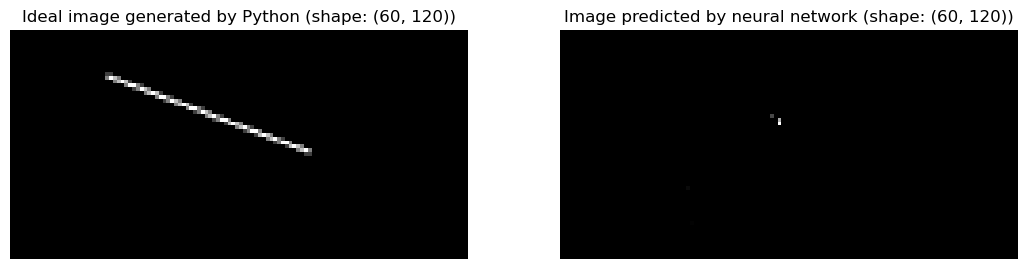

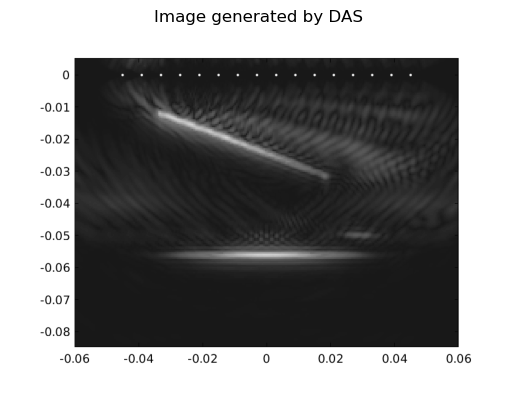

In [372]:
filename = 'fmc_3601_0'

def check_result_with_offset(model, filename):
    [_, index, noise_level] = filename.split('_')

    print(f'Image index: {index}')
    print(f'Image noise level: {noise_level}')

    # 1. Plotting the true_img (ideal image) generated by python 

    img_resize_factor = 50

    true_img_dirname = '/Users/chenkangan/PycharmProjects/ME4_FYP_py/py_output_fig_no_backwall_crop'

    true_img = cv.imread(f'{true_img_dirname}/defect_{index}_yshift_60.png',cv.IMREAD_GRAYSCALE)
    true_img_scale = img_resize(true_img, scale_percent = img_resize_factor) # Resize the image

    fig, ax = plt.subplots(1,2, figsize = [13,5])
    ax[0].imshow(true_img_scale, cmap ='gray')
    ax[0].set_title(f'Ideal image generated by Python (shape: {true_img_scale.shape})')
    ax[0].axis('off')

    # 2. Plotting the image predicted by Python
    fmc_dirname = '/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/FMC_variable_offset'
    mat = scipy.io.loadmat(f'{fmc_dirname}/{filename}.mat')
    fmc = mat['timeTraces'][::5] # Subsampling 
    X_test = fmc.reshape(1, 895, 16, 16, 1) # Reshaping
    X_test = X_test/1.75e-14 # Scaling

    threshold = -0.1

    ypred = model.predict(X_test[0].reshape(-1, 895, 16, 16))
    ypred[ypred <= threshold] = 0
    ypred[ypred > threshold] = np.abs(ypred[ypred > threshold])*255
    img = ypred.reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))

    ax[1].imshow(img, cmap ='gray')
    ax[1].set_title(f'Image predicted by neural network (shape: {img.shape})')
    ax[1].axis('off')


    # 3. Plotting the DAS image produced by MATLAB
    das_fmc_dirName = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_offset"
    # Read image in greyscale 
    image_das_fmc = cv.imread(f'{das_fmc_dirName}/Figure_{index}.png',cv.IMREAD_GRAYSCALE)  # convert to array
    fig, ax = plt.subplots()
    plt.imshow(image_das_fmc, cmap='gray')
    plt.title('Image generated by DAS')
    plt.axis('off')
    plt.show()
    
check_result_with_offset(model, filename = 'fmc_3601_0')

## Keras Tuner Result Summary

In [154]:

def read_keras_tuner_log(filename):

    with open(f'Keras_tuner_log/{filename}.txt') as f:
        contents = f.read().splitlines()
        
    j = 0
    while contents[j] != 'Trial summary':
        j += 1
    info = contents[:j]
    print(info)
    result = contents[j:]

    rank = 0
    model_compile = []
    for i in range(len(result)):
        if result[i] == 'Trial summary':
            rank += 1
            pass
        elif result[i] == 'Hyperparameters:':
            model = {}
            model['Rank'] = rank
        else:
            key, value = result[i].split(': ')
            if key == 'Score':
                model['Val_loss'] = value
                model_compile.append(model)
            else:
                model[key] = value
            

    df = pd.DataFrame.from_dict(model_compile).set_index('Rank')
    df = df.drop(['tuner/epochs','tuner/initial_epoch','tuner/bracket','tuner/round','tuner/trial_id'], axis = 1)
    
    return df


# This function produce code from keras tuner log
def model_builder_from_kt(df, dimension):
    
    layers = int(df['layers'])
    dense_layers = int(df['dense_layers'])
    
    for i in range(layers):
        filters = df[f'filters_{i}'].values[0]
        kernels = df[f'kernels_{i}'].values[0]
        dropout = df[f'dropout_{i}'].values[0]
        pooling = df[f'pooling_{i}'].values[0]
        
        if dimension == 3:
            activation = df[f'activation_{i}'].values[0]
            print(f"model.add(Conv3D(filters={filters}, kernel_size=({kernels}, 3, 3), strides=(1, 1, 1), activation='{activation}'))")
            
            if dropout == 'True': print('model.add(Dropout(0.1))')
            elif dropout == 'False': pass
            
            if pooling == 'max':
                print('model.add(MaxPool3D())')
            elif pooling == 'avg':
                print('model.add(AveragePooling3D())')
                
        elif dimension == 2:
            activation = df[f'activation1_{i}'].values[0]
            print(f"model.add(Conv2D(filters={filters}, kernel_size=({kernels}, 3), strides=(1, 1), activation='{activation}'))")
            
            if dropout == 'True': print('model.add(Dropout(0.1))')
            elif dropout == 'False': pass
            
            if pooling == 'max':
                print('model.add(MaxPool2D())')
            elif pooling == 'avg':
                print('model.add(AveragePooling2D())')       
        
    print('model.add(Flatten())')
    for j in range(dense_layers):
        dense_unit = df[f'dense_units_{j}'].values[0]
        try:
            activation2 = df[f'activation2_{j}'].values[0]
        except:
            activation2 = 'softsign'
        dropout2 = df[f'dropout2_{j}'].values[0]
        
        print(f"model.add(Dense(units={dense_unit}, activation='{activation2}'))")
        
        if dropout2 == 'True': print('model.add(Dropout(0.1))')
        elif dropout2 == 'False': pass
        
    print("model.add(Dense(units=output_size, activation='tanh'))")
    lr = float(df['lr'])
    print(f'learning_rate = {lr}')

    print("model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),")
    print("              loss='mean_squared_error',")
    print("              metrics=[tf.keras.metrics.MeanSquaredError()])")

    print('return model')

In [315]:
# 3D model limit the number of dense_layers to be 1, did not differentiate the activation function (2000 samples)
# 1/3/23
pd.set_option('display.max_columns', None)
df = read_keras_tuner_log('3D_2000_o7121864')
df

['Message 1:', 'Num GPUs Available:  0', '______', 'The shape of X is (2000, 895, 16, 16, 1)', 'The shape of y is (2000, 7200)', 'Results summary', 'Results in fyp_model_search/3dcnn_1conv_all_gpu', 'Showing 10 best trials', '<keras_tuner.engine.objective.Objective object at 0x145c21f8a2b0>']


,layers,filters_0,kernels_0,activation_,dropout,pooling_0,dense_units_,dropout2,lr,filters_1,kernels_1,pooling_1,Val_loss
Rank,,,,,,,,,,,,,
1,1,5,4,tanh,True,max,1000,True,0.0001735701471314462,2,5,avg,0.020990939810872078
2,1,12,5,relu,True,avg,1500,True,0.0001217170995230137,3,5,max,0.021442623808979988
3,1,5,4,tanh,True,max,1000,True,0.0001735701471314462,2,5,avg,0.026099970564246178
4,1,12,5,relu,True,avg,1500,True,0.0001217170995230137,3,5,max,0.028639812022447586
5,1,16,5,tanh,False,avg,2000,True,0.00011159040326724652,15,4,max,0.029070377349853516
6,1,11,5,tanh,False,avg,1000,False,0.00011750076109837058,4,5,avg,0.030609704554080963
7,1,16,5,tanh,False,avg,2000,True,0.00011159040326724652,15,4,max,0.03066534921526909
8,1,11,5,tanh,False,avg,1000,False,0.00011750076109837058,4,5,avg,0.03070610947906971
9,1,12,5,relu,True,avg,1500,True,0.0001217170995230137,3,5,max,0.030805451795458794


In [373]:
# 3D model limit the dense activation function to be softsign (2000 samples)
# Lowest loss
# 1/3/23
pd.set_option('display.max_columns', None)
df = read_keras_tuner_log('3D_2000_o7127128')
model_builder_from_kt(df[df.index == 1], 3)
model_builder_from_kt(df[df.index == 2], 3)
df

['Message 1:', 'Num GPUs Available:  0', '______', 'The shape of X is (2000, 895, 16, 16, 1)', 'The shape of y is (2000, 7200)', 'Results summary', 'Results in fyp_model_search/3dcnn_1conv_all_gpu_2', 'Showing 10 best trials', '<keras_tuner.engine.objective.Objective object at 0x1530908d82b0>']
model.add(Conv3D(filters=10, kernel_size=(5, 3, 3), strides=(1, 1, 1), activation='relu'))
model.add(MaxPool3D())
model.add(Flatten())
model.add(Dense(units=1500, activation='softsign'))
model.add(Dense(units=output_size, activation='tanh'))
learning_rate = 0.00017533560552392052
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanSquaredError()])
return model
model.add(Conv3D(filters=4, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='tanh'))
model.add(Dropout(0.1))
model.add(MaxPool3D())
model.add(Flatten())
model.add(Dense(units=1000, activation='softsign'))
model.add(Dense(uni

,layers,filters_0,kernels_0,activation_0,dropout_0,pooling_0,dense_layers,dense_units_0,dropout2_0,lr,filters_1,kernels_1,activation_1,dropout_1,pooling_1,dense_units_1,dropout2_1,Val_loss
Rank,,,,,,,,,,,,,,,,,,
1,1,10,5,relu,False,max,1,1500,False,0.00017533560552392052,8,3,relu,False,max,500,False,0.020990509539842606
2,1,4,3,tanh,True,max,1,1000,False,0.0001960411264334168,5,3,tanh,False,avg,1500,True,0.02116321586072445
3,1,5,5,relu,True,max,1,500,False,0.00033995444170334535,15,4,relu,False,max,1000,True,0.021186308935284615
4,1,3,4,relu,False,max,1,1000,True,0.00012850284319400977,14,3,tanh,False,avg,500,False,0.02122516930103302
5,1,4,4,relu,False,max,1,1500,True,0.0003006565089897389,6,4,relu,True,avg,1500,True,0.021480949595570564
6,1,16,4,tanh,True,max,1,500,True,0.0003964634221273707,11,5,relu,True,avg,1000,False,0.02158622443675995
7,1,4,4,relu,False,max,1,1500,True,0.0003006565089897389,6,4,relu,True,avg,1500,True,0.022245878353714943
8,1,9,5,tanh,False,max,2,1000,False,0.0001231004831757312,8,5,relu,True,max,2000,True,0.022514265030622482
9,1,10,5,relu,False,max,1,1500,False,0.00017533560552392052,8,3,relu,False,max,500,False,0.022540545091032982


In [247]:
# 3D model does not limit the dense activation function to be softsign (2000 samples)
# 7/3/23
pd.set_option('display.max_columns', None)
df = read_keras_tuner_log('3D_2000_o7158970') 
model_builder_from_kt(df[df.index == 1], 3)
df

['Message 1:', 'Num GPUs Available:  0', '______', 'The shape of X is (2000, 895, 16, 16, 1)', 'The shape of y is (2000, 7200)', 'Results summary', 'Results in fyp_model_search/3dcnn_all_gpu_V1', 'Showing 10 best trials', '<keras_tuner.engine.objective.Objective object at 0x14bf8e8072b0>']
model.add(Conv3D(filters=2, kernel_size=(5, 3, 3), strides=(1, 1, 1), activation='relu'))
model.add(MaxPool3D())
model.add(Flatten())
model.add(Dense(units=1500, activation='softsign'))
model.add(Dropout(0.1))
model.add(Dense(units=output_size, activation='tanh'))
learning_rate = 0.00011146694480809503
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanSquaredError()])
return model


,layers,filters_0,kernels_0,activation_0,dropout_0,pooling_0,dense_layers,dense_units_0,activation2_0,dropout2_0,lr,filters_1,kernels_1,activation_1,dropout_1,pooling_1,dense_units_1,activation2_1,dropout2_1,Val_loss
Rank,,,,,,,,,,,,,,,,,,,,
1,1,2,5,relu,False,max,1,1500,softsign,True,0.00011146694480809503,3,4,relu,True,max,500,softsign,False,0.021222470328211784
2,1,3,4,relu,True,max,2,1000,softsign,True,0.0001407202210799421,3,3,relu,False,max,2000,softsign,False,0.022488880902528763
3,1,13,3,tanh,False,max,2,500,tanh,True,0.00010034321114853268,10,5,tanh,False,max,1500,tanh,True,0.022556554526090622
4,1,5,4,relu,True,max,1,1000,tanh,False,0.0008181203226443354,9,3,relu,True,avg,500,tanh,True,0.023752612993121147
5,1,4,4,tanh,True,max,1,500,tanh,False,0.0016810101581393511,6,3,tanh,False,max,1500,softsign,True,0.023874888196587563
6,1,5,4,relu,True,max,1,1000,tanh,False,0.0008181203226443354,9,3,relu,True,avg,500,tanh,True,0.024313174188137054
7,2,13,4,relu,False,max,2,500,tanh,True,0.00022635543607274578,6,4,relu,False,max,1500,softsign,True,0.024648286402225494
8,2,1,4,tanh,False,max,1,1000,softsign,False,0.00011862622817678188,13,5,tanh,False,max,1000,tanh,True,0.024709071964025497
9,2,3,3,relu,False,avg,1,2000,tanh,True,0.00013428186382661135,5,3,relu,True,max,500,softsign,True,0.025620855391025543


In [190]:
# 2D model with 70% training data 2450 (Currently the best tuner for 2D)
# 8/3/23
pd.set_option('display.max_columns', None)

# NOTE: FOR SOME REASONS, RANK 1 AND 2 ARE EXACTLY THE SAME MODEL
# RANK 5 AND 6 ARE EXACTLY THE SAME MODEL
df = read_keras_tuner_log('2D_2450_o7165279')
rank = 7
model_builder_from_kt(df[df.index == rank], 2)
print('')
df[df.index == rank]
# df

['Message 1:', 'Num GPUs Available:  0', '______', 'The shape of X is (2450, 895, 16, 16, 1)', 'The shape of y is (2450, 7200)', 'Results summary', 'Results in fyp_model_search/2dcnn_all_gpu_V1', 'Showing 10 best trials', '<keras_tuner.engine.objective.Objective object at 0x14c7a8c5a370>']
model.add(Conv2D(filters=10, kernel_size=(4, 3), strides=(1, 1), activation='tanh'))
model.add(Dropout(0.1))
model.add(AveragePooling2D())
model.add(Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(units=2000, activation='softsign'))
model.add(Dropout(0.1))
model.add(Dense(units=output_size, activation='tanh'))
learning_rate = 0.0001002744916948696
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanSquaredError()])
return model



,layers,filters_0,kernels_0,activation1_0,dropout_0,pooling_0,dense_layers,dense_units_0,activation2_0,dropout2_0,lr,filters_1,kernels_1,activation1_1,dropout_1,pooling_1,filters_2,kernels_2,activation1_2,dropout_2,pooling_2,filters_3,kernels_3,activation1_3,dropout_3,pooling_3,dense_units_1,activation2_1,dropout2_1,filters_4,kernels_4,activation1_4,dropout_4,pooling_4,Val_loss
Rank,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,2,10,4,tanh,True,avg,1,2000,softsign,True,0.0001002744916948696,8,3,relu,False,avg,5,3,tanh,True,avg,7,5,tanh,True,avg,1000,softsign,False,9,3,relu,False,avg,0.025665177032351494


In [249]:
# 3D model with 70% training data 2450 (Currently the best tuner for 3D)
# 8/3/23
pd.set_option('display.max_columns', None)
df = read_keras_tuner_log('3D_2450_o7167535') 
model_builder_from_kt(df[df.index == 1], 3)
df

['Message 1:', 'Num GPUs Available:  0', '______', 'Results summary', 'Results in fyp_model_search/3dcnn_all_gpu_V2', 'Showing 10 best trials', '<keras_tuner.engine.objective.Objective object at 0x14dff1644370>']
model.add(Conv3D(filters=6, kernel_size=(4, 3, 3), strides=(1, 1, 1), activation='tanh'))
model.add(Dropout(0.1))
model.add(MaxPool3D())
model.add(Flatten())
model.add(Dense(units=2000, activation='tanh'))
model.add(Dense(units=output_size, activation='tanh'))
learning_rate = 0.00019617145132549103
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanSquaredError()])
return model


,layers,filters_0,kernels_0,activation_0,dropout_0,pooling_0,dense_layers,dense_units_0,activation2_0,dropout2_0,lr,filters_1,kernels_1,activation_1,dropout_1,pooling_1,dense_units_1,activation2_1,dropout2_1,Val_loss
Rank,,,,,,,,,,,,,,,,,,,,
1,1,6,4,tanh,True,max,1,2000,tanh,False,0.00019617145132549103,15,3,tanh,False,avg,500,softsign,False,0.025411486625671387
2,1,6,4,tanh,True,max,1,2000,tanh,False,0.00019617145132549103,15,3,tanh,False,avg,500,softsign,False,0.025448424741625786
3,1,1,3,tanh,False,max,1,500,tanh,False,0.00032888370410083404,16,3,relu,False,avg,1500,softsign,True,0.025469934567809105
4,1,13,5,relu,False,max,2,1000,tanh,True,0.00012575252496942966,13,3,relu,True,avg,1500,tanh,False,0.02568845823407173
5,1,12,4,relu,True,max,2,1000,tanh,False,0.0002662432681570655,3,5,relu,False,max,1000,tanh,False,0.025830769911408424
6,1,12,4,relu,True,max,2,1000,tanh,False,0.0002662432681570655,3,5,relu,False,max,1000,tanh,False,0.026058094576001167
7,1,5,4,tanh,True,max,1,500,tanh,True,0.0003225322175050357,1,3,relu,True,avg,1000,softsign,False,0.026228033006191254
8,1,13,5,relu,False,max,2,1000,tanh,True,0.00012575252496942966,13,3,relu,True,avg,1500,tanh,False,0.02623068168759346
9,1,5,5,tanh,True,max,1,1000,tanh,False,0.0005102221324388098,7,4,relu,True,avg,2000,softsign,False,0.026232779026031494


# ConvNet shape calculator

In [5]:
def ConvSize(input_shape = [895, 16, 16], stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0):
    out_shape = []
    for i in range(len(input_shape)):
        out = (input_shape[i] - kernal_shape[i] + 2 * zero_pad)/stride[i] + 1
        out_shape.append(out)
    return out_shape

def Pooling(input_shape = [895, 16, 16], stride = [2, 2, 2], pool_shape = [2, 2, 2]):
    out_shape = []
    for i in range(len(input_shape)):
        out = np.floor((input_shape[i] - pool_shape[i]) / stride[i]) + 1
        out_shape.append(out)
    return out_shape
    

### 3D model|

In [6]:
# Maximum 2 conv layer followed by 2 pool layer
lay1 = ConvSize(input_shape = [895, 16, 16], stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
pool1 = Pooling(input_shape = lay1, stride = [2, 2, 2], pool_shape = [2, 2, 2])
lay2 = ConvSize(input_shape = pool1, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
pool2 = Pooling(input_shape = lay2, stride = [2, 2, 2], pool_shape = [2, 2, 2])
lay3 = ConvSize(input_shape = pool2, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay3

[220.0, 0.0, 0.0]

In [7]:
# Maximum 7 conv layer followed by 1 pool layer
lay1 = ConvSize(input_shape = [895, 16, 16], stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay2 = ConvSize(input_shape = lay1, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay3 = ConvSize(input_shape = lay2, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay4 = ConvSize(input_shape = lay3, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay5 = ConvSize(input_shape = lay4, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay6 = ConvSize(input_shape = lay5, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay7 = ConvSize(input_shape = lay6, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
pool1 = Pooling(input_shape = lay7, stride = [2, 2, 2], pool_shape = [2, 2, 2])
pool1

[440.0, 1.0, 1.0]

### 2D model

In [10]:
ConvSize(input_shape = [895, 256], stride = [1, 1], kernal_shape = [3, 3], zero_pad = 0)

[893.0, 254.0]

In [8]:
x_dimension = 2
img_resize_factor = 50
shrinkx = False

X, y = load_training_data(num_sample=100, 
                          x_dimension=x_dimension, 
                          img_resize_factor=img_resize_factor,
                          shrinkx = shrinkx)

The shape of X is (100, 895, 256, 1)
The shape of y is (100, 7200)


## 3D Model Cross-validation Result Analysis 13/3/23

In [8]:
model_name_dict = {1: '3D_2450_o7167535',
                   2: '3D_2000_o7158970',
                   3: '3D_2000_o7127128',
                   4: '3D_2000_o7121864',
                   5: '3D_2000_o7127128-2'}

def get_loss_val_loss(model_num):
    
    if model_num == 3:
        loss = [0.0016700209816917777, 0.0015131579712033272, 0.0016506352694705129, 0.001560979406349361, 0.0019041020423173904]
        val_loss = [0.027529317885637283, 0.02754729799926281, 0.02718711830675602, 0.027615569531917572, 0.028100095689296722]
        avg_loss = np.mean(loss)
        avg_val_loss = np.mean(val_loss)
        
    else:
        df = pd.read_csv(f'NN_model/model_training_log/{model_name_dict[model_num]}_kv_training_log.csv').drop('Unnamed: 0', axis = 1)
        avg_loss = df.iloc[-1][['loss_1', 'loss_2', 'loss_3', 'loss_4', 'loss_5']].mean()
        avg_val_loss = df.iloc[-1][['Val_loss_1', 'Val_loss_2', 'Val_loss_3', 'Val_loss_4', 'Val_loss_5']].mean()
    
    return avg_loss, avg_val_loss


avg_loss_lst = []
avg_val_loss_lst = []

for i in range(1, 6):
    loss, val_loss = get_loss_val_loss(i)
    avg_loss_lst.append(loss)
    avg_val_loss_lst.append(val_loss)


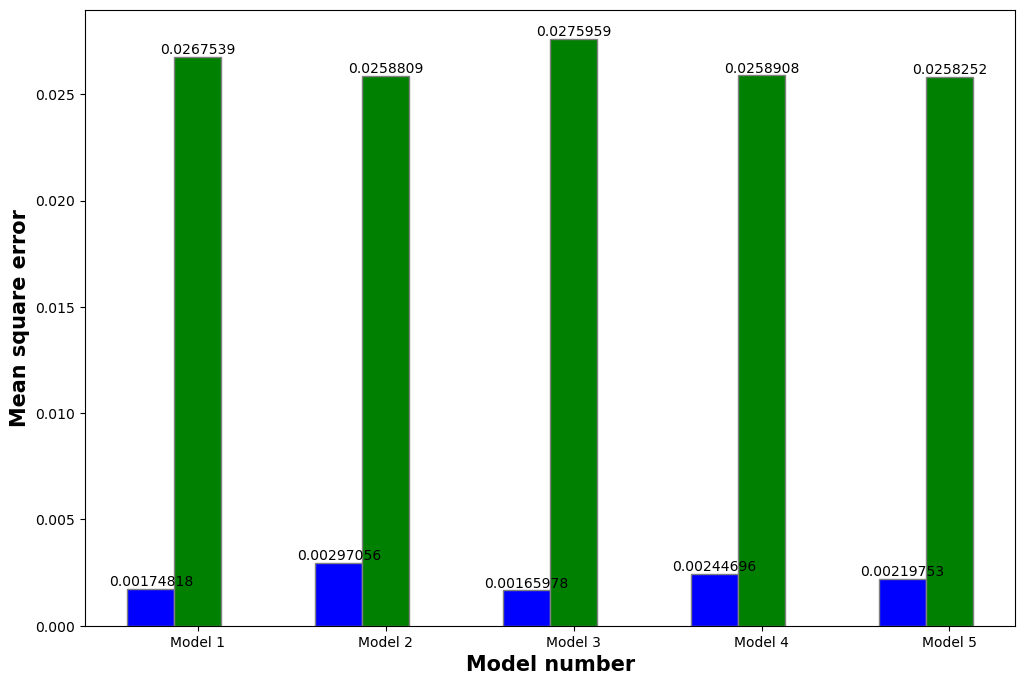

In [10]:
# set width of bar
barWidth = 0.25
fig, ax = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(avg_loss_lst))
br2 = [x + barWidth for x in br1]

# Make the plot
ax.bar(br1, avg_loss_lst, color ='b', width = barWidth,
        edgecolor ='grey', label ='loss')


ax.bar(br2, avg_val_loss_lst, color ='g', width = barWidth,
        edgecolor ='grey', label ='validation loss')

 
# Adding Xticks
ax.set_xlabel('Model number', fontweight ='bold', fontsize = 15)
ax.set_ylabel('Mean square error', fontweight ='bold', fontsize = 15)
ax.set_xticks([r + barWidth for r in range(len(br1))],
        ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
 

for bars in ax.containers:
    ax.bar_label(bars)


## 2D Model Cross-validation Result Analysis 20/3/23

In [12]:
model_name_dict = {1: '2D_2450_o7165279-1',
                   2: '2D_2450_o7165279-3',
                   3: '2D_2450_o7165279-4',
                   4: '2D_2450_o7165279-5',
                   5: '2D_2450_o7165279-7'}

def get_loss_val_loss(model_num):
    
    if model_num == 1:
        loss = [0.0013804493937641382, 0.0013785709161311388, 0.0015361564001068473, 0.0011171853402629495, 0.001235821982845664]
        val_loss = [0.024945316836237907, 0.024640046060085297, 0.02449222281575203, 0.025287294760346413, 0.024686506018042564]
        avg_loss = np.mean(loss)
        avg_val_loss = np.mean(val_loss)
        
    else:
        df = pd.read_csv(f'NN_model/model_training_log/{model_name_dict[model_num]}_kv_training_log.csv').drop('Unnamed: 0', axis = 1)
        avg_loss = df.iloc[-1][['loss_1', 'loss_2', 'loss_3', 'loss_4', 'loss_5']].mean()
        avg_val_loss = df.iloc[-1][['Val_loss_1', 'Val_loss_2', 'Val_loss_3', 'Val_loss_4', 'Val_loss_5']].mean()
    
    return avg_loss, avg_val_loss


avg_loss_lst = []
avg_val_loss_lst = []

for i in range(1, 6):
    loss, val_loss = get_loss_val_loss(i)
    avg_loss_lst.append(loss)
    avg_val_loss_lst.append(val_loss)

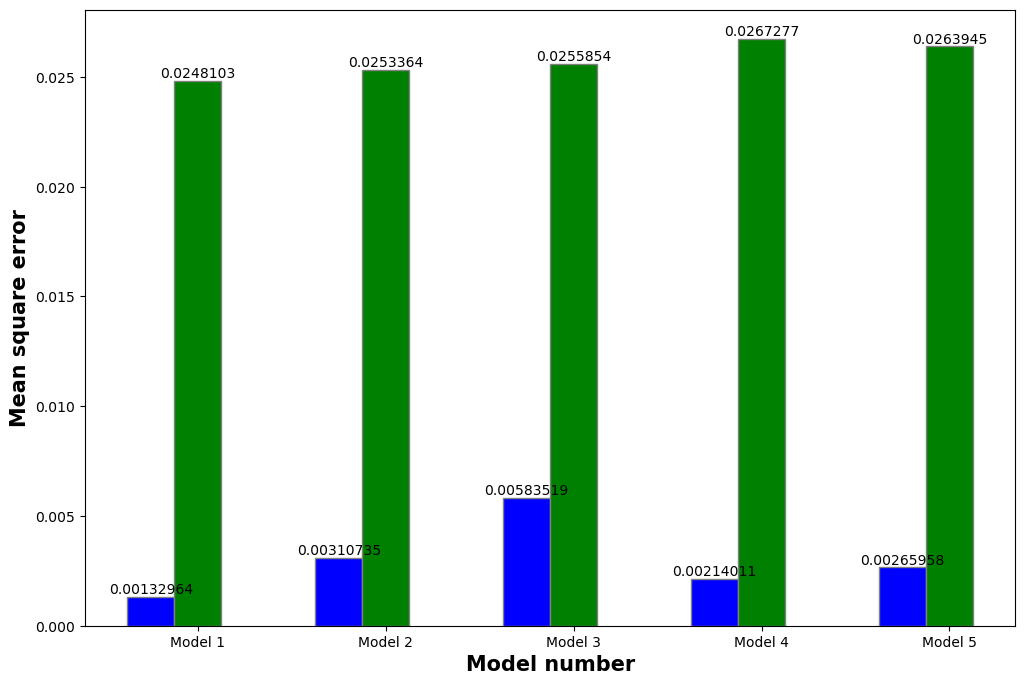

In [13]:
# set width of bar
barWidth = 0.25
fig, ax = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(avg_loss_lst))
br2 = [x + barWidth for x in br1]

# Make the plot
ax.bar(br1, avg_loss_lst, color ='b', width = barWidth,
        edgecolor ='grey', label ='loss')


ax.bar(br2, avg_val_loss_lst, color ='g', width = barWidth,
        edgecolor ='grey', label ='validation loss')

 
# Adding Xticks
ax.set_xlabel('Model number', fontweight ='bold', fontsize = 15)
ax.set_ylabel('Mean square error', fontweight ='bold', fontsize = 15)
ax.set_xticks([r + barWidth for r in range(len(br1))],
        ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
 

for bars in ax.containers:
    ax.bar_label(bars)


## Extract information from the training log and visualise the training process 9/3/23

In [316]:

def training_log_extractor(filename, save = True):

    import re
    with open(f'NN_model/model_training_log/{filename}.txt') as f:
        contents = f.read().splitlines()

    useful_text, model_name = [], []
    for i in range(len(contents)):    
        if len(re.findall('step', contents[i])) != 0:
            useful_text.append(contents[i])
        if len(re.findall('name', contents[i])) != 0:
            model_name.append(contents[i].split(' ')[-1])


    model_dict = {}
    for j in range(len(model_name)):
        model_dict[model_name[j]] = useful_text[100*j : 100*j+100]

    # Extract loss and val_loss from the text, first split by ' - ', 
    # then ':' and then strip to remove empty space\
    # finally, convert str to float

    for k in range(len(model_name)):
        loss_lst, val_loss_lst = [], []
        for x in range(0, 100):
            loss = float(model_dict[model_name[k]][x].split(' - ')[2].split(':')[-1].strip())
            val_loss = float(model_dict[model_name[k]][x].split(' - ')[4].split(':')[-1].strip())
            loss_lst.append(loss)
            val_loss_lst.append(val_loss)
        df = pd.DataFrame({'loss':loss_lst, 'val_loss':val_loss})
        plt.figure(figsize = (10,3))
        plt.plot(loss_lst, label = 'mse loss')
        plt.plot(val_loss_lst, label = 'mse validation loss')
        plt.title(f'{model_name[k]}_training_log\n Final loss: {loss_lst[-1]}; Final val loss: {val_loss_lst[-1]}')
        plt.ylabel('mse loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.show()
        if save == True:
            df.to_csv(f'NN_model/model_training_log/{model_name[k]}_training_log.csv')
        

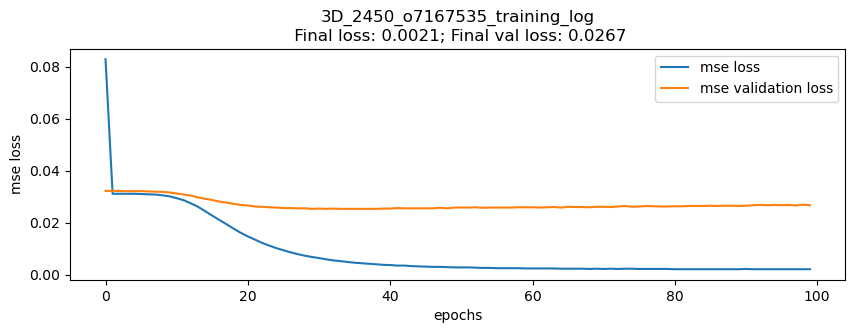

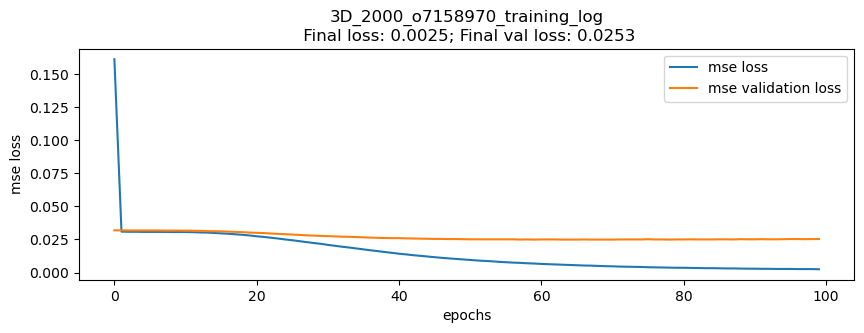

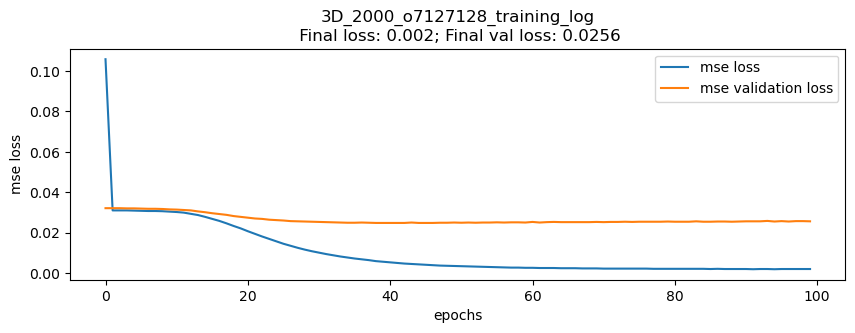

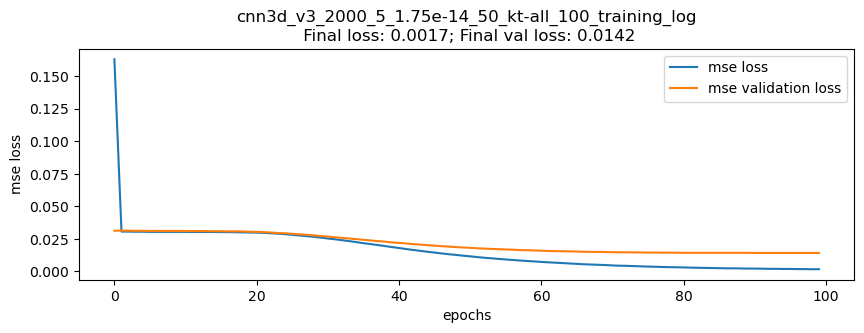

In [311]:
training_log_extractor('3_model_test_o7169960', save = True)
training_log_extractor('1_model_test_o7117486', save = True)

## Dealing with unsuccessful log for 3d model 3 (13/3/23)

In [404]:
# Unsuccessful 3d model 
import re
filename = '3d_model_3_failed_log_o7201023'
filename = '3d_model_3_failed_log_o7201555'
with open(f'NN_model/model_training_log/Unsuccess_log/{filename}.txt') as f:
    contents = f.read().splitlines()

useful_text, model_name = [], []
for i in range(len(contents)):    
    if len(re.findall('Score', contents[i])) != 0:
        useful_text.append(contents[i])
    if len(re.findall('name', contents[i])) != 0:
        model_name.append(contents[i].split(' ')[-1])
        
useful_text

['Score_for_fold_1 - loss: 0.001560979406349361 - val_loss: 0.027615569531917572',
 'Score_for_fold_2 - loss: 0.0019041020423173904 - val_loss: 0.028100095689296722',
 'Score_for_fold_3 - loss: 0.0016143610700964928 - val_loss: 0.028062794357538223']

In [5]:
# Unsuccessful 2d model
import re
filename = '2d_model_1_failed_log_o7254752'
filename = '2d_model_1_failed_log_o7255050'
filename = '2d_model_1_failed_log_o7255310'
with open(f'NN_model/model_training_log/Unsuccess_log/{filename}.txt') as f:
    contents = f.read().splitlines()

useful_text, model_name = [], []
for i in range(len(contents)):    
    if len(re.findall('Score', contents[i])) != 0:
        useful_text.append(contents[i])
    if len(re.findall('name', contents[i])) != 0:
        model_name.append(contents[i].split(' ')[-1])
        
useful_text


['Score_for_fold_1 - loss: 0.001235821982845664 - val_loss: 0.024686506018042564',
 'Score_for_fold_2 - loss: 0.0013977807248011231 - val_loss: 0.02499934658408165']